In [1]:
import sys
import pandas as pd
sys.path.append('../..')

# Creature

In [2]:
from lamarck import Creature

In [3]:
genome = {
    'x': 10,
    'y': 'A',
    'z': (1, 2, 3)
}

In [4]:
creature = Creature(genome)

In [5]:
creature.id

-8096318841226225762

# Genome Creator

In [6]:
from lamarck.assistant import GenomeCreator

In [7]:
genome_creator = GenomeCreator()

In [8]:
genome_creator.add_gene_specs.numeric(name='x',
                                      min=0,
                                      max=10,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.categorical(name='y', domain=['A', 'B', 'C'])

genome_creator.add_gene_specs.vectorial(name='z', length=3, replace=False, domain=['i', 'j', 'k'])

In [9]:
genome_blueprint = genome_creator.get_genome_blueprint()

In [10]:
genome_blueprint

{'x': {'type': 'numeric',
  'domain': 'int',
  'ranges': {'min': 0, 'max': 10, 'progression': 'linear'}},
 'y': {'type': 'categorical', 'domain': ['A', 'B', 'C']},
 'z': {'type': 'vectorial',
  'domain': ['i', 'j', 'k'],
  'ranges': {'length': 3, 'replace': False}}}

# Population Creator

In [11]:
from lamarck.assistant import PopulationCreator

In [12]:
pop_creator = PopulationCreator(genome_blueprint)

In [13]:
popdet = pop_creator.create.det(3)
popdet

Population with 27 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [14]:
popdet.datasets.main.head()

,x,y,z
0,0,A,"(i, j, k)"
1,0,A,"(j, i, k)"
2,0,A,"(k, i, j)"
3,0,B,"(i, j, k)"
4,0,B,"(j, i, k)"


In [15]:
poprand = pop_creator.create.rand(30)
poprand

Population with 30 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [16]:
poprand.datasets.input.head()

,x,y,z
id,,,
-4668083703657647885,5,A,"(i, k, j)"
3486247781584091490,2,A,"(j, i, k)"
-9092990305601262301,6,A,"(j, i, k)"
-6187115630984698000,0,A,"(i, k, j)"
-6861734443741316291,0,B,"(i, k, j)"


In [17]:
popdirty = popdet + poprand
popdirty

Population with 57 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [18]:
popdirty.datasets.input.head()

,x,y,z
id,,,
-1854844504706046034,0,A,"(i, j, k)"
-90267742121588547,0,A,"(j, i, k)"
-8058383388950173790,0,A,"(k, i, j)"
-2529463317462664325,0,B,"(i, j, k)"
-764886554878206838,0,B,"(j, i, k)"


In [19]:
pop = popdirty.drop_duplicates()
pop

Population with 54 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [20]:
pop.datasets.input.head()

,x,y,z
id,,,
-1854844504706046034,0,A,"(i, j, k)"
-90267742121588547,0,A,"(j, i, k)"
-8058383388950173790,0,A,"(k, i, j)"
-2529463317462664325,0,B,"(i, j, k)"
-764886554878206838,0,B,"(j, i, k)"


# Environment

In [21]:
from lamarck import Environment

In [22]:
import hashlib

def tuplehash(tuple_obj):
    encoded = ''.join(tuple_obj).encode()
    m = hashlib.md5()
    m.update(encoded)
    d = m.digest()
    return int.from_bytes(d, 'big')
    
    
def dummy_process(x, y, z):
    zval = (tuplehash(z) % 1000) / (x+1)**0.75
    yval = zval // ord(y) + tuplehash((y, y)) % 19
    return {
        'time': (x + 1) * (zval - yval) // 10,
        'profit': (zval - 2*yval)**(x/10 + 1) // (tuplehash((y, y)) % 7 + 1)
    }

In [23]:
env = Environment()

In [24]:
env.config.set_process(dummy_process)

In [25]:
env.config.set_output_varibles('time', 'profit')

In [26]:
env.config

multi:   False
output_varibles:   ('time', 'profit')
process:   <function dummy_process at 0x7ff8eba54790>

In [27]:
cr = pop[10]
cr

Creature <-5617265103429395257> - genome: {'x': 5, 'y': 'A', 'z': ('j', 'i', 'k')}

### Simulate Creature

In [28]:
env.simulate(cr)

{'time': 47.0, 'profit': 71.0}

### Simulate Population

In [29]:
simpop = env.simulate(pop)

In [30]:
simpop

Population with 54 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [31]:
simpop.datasets.output.head()

,x,y,z,time,profit
-1854844504706046034,0,A,"(i, j, k)",82.0,114.0
-90267742121588547,0,A,"(j, i, k)",34.0,46.0
-8058383388950173790,0,A,"(k, i, j)",72.0,99.0
-2529463317462664325,0,B,"(i, j, k)",83.0,811.0
-764886554878206838,0,B,"(j, i, k)",34.0,332.0


### Simulate Population - Multi Thread

In [32]:
env.config.set_multi(True)

In [33]:
simpop = env.simulate(pop)

In [34]:
simpop.datasets.output.head()

,x,y,z,time,profit
-1854844504706046034,0,A,"(i, j, k)",82.0,114.0
-90267742121588547,0,A,"(j, i, k)",34.0,46.0
-8058383388950173790,0,A,"(k, i, j)",72.0,99.0
-2529463317462664325,0,B,"(i, j, k)",83.0,811.0
-764886554878206838,0,B,"(j, i, k)",34.0,332.0


# Fitness

### 1. Single Objective

In [37]:
single_objective_pop = simpop.fitness.single_objective(output='time', objective='min')

In [134]:
single_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria
id,,,,,,
-90267742121588547,0,A,"(j, i, k)",34.0,46.0,34.0
-764886554878206838,0,B,"(j, i, k)",34.0,332.0,34.0
3576471659784649787,0,C,"(j, i, k)",35.0,86.0,35.0
3486247781584091490,2,A,"(j, i, k)",42.0,47.0,42.0
-6187115630984698000,0,A,"(i, k, j)",45.0,62.0,45.0


### 2. Multi Objective - Ranked

In [42]:
ranked_objective_pop = simpop.fitness.multi_objective.ranked(priorities=['time', 'profit'], objectives=['min', 'max'])

In [43]:
ranked_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1
id,,,,,,,
-764886554878206838,0,B,"(j, i, k)",34.0,332.0,34.0,332.0
-90267742121588547,0,A,"(j, i, k)",34.0,46.0,34.0,46.0
3576471659784649787,0,C,"(j, i, k)",35.0,86.0,35.0,86.0
3486247781584091490,2,A,"(j, i, k)",42.0,47.0,42.0,47.0
-6187115630984698000,0,A,"(i, k, j)",45.0,62.0,45.0,62.0


### 3. Multi Objective - Pareto

In [ ]:
pareto_objective_pop = simpop.apply_fitness.multi_objective.ranked(outputs=['time', 'profit'], objectives=['min', 'max'])

In [ ]:
pareto_objective_pop.datasets.fitness.head()

In [204]:
import numpy as np

In [205]:
criteria_cols = ['criteria0', 'criteria1']
objectives = ['min', 'max']

In [206]:
def compare(x, s, objective):
    if objective == 'min':
        return s < x
    elif objective == 'max':
        return s > x

In [228]:
df = ranked_objective_pop.datasets.fitness
index = df.index
size = len(df)
fronts = pd.Series(np.zeros(size), index=index, dtype=int)

In [229]:
dom = pd.Series(np.empty(size), dtype=object, index=index)
for i in index:
    f = np.ones(size, dtype=bool)
    for col, objective in zip(criteria_cols, objectives):
        s = df[col]
        x = s.loc[i]
        f = f & compare(x, s, objective)
    dom.loc[i] = index[f]

In [230]:
lens = lambda x: len(x)
front = 0
while any(fronts == 0):
    front += 1
    f = (dom.map(lens) == 0) & (fronts == 0)
    fronts.loc[f[f].index] = front
    dominated_index = f[~f].index
    new_dom = dom[dominated_index]
    for idx, d in zip(dominated_index, new_dom):
        new_d = d.drop(f[f].index, errors='ignore')
        new_dom[idx] = new_d
    dom[dominated_index] = new_dom

In [252]:
df = df.assign(front=fronts)

<AxesSubplot:xlabel='criteria0', ylabel='criteria1'>

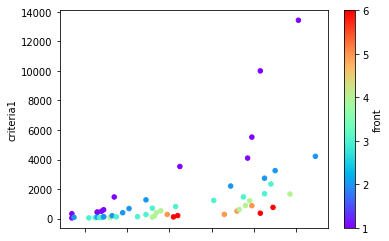

In [253]:
df.plot.scatter(*criteria_cols, c='front', colormap='rainbow')

# Selection